In [ ]:
# Importing necessary libraries

import sys
import math
from scipy.signal import *

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Parameters definition - unit

carrier_freq = 1000000 # Hz
offset_freq = 960 # Hz
rotation_freq = 30 # Hz
distance = 200000 # m
light_speed = 300000000 # m/s
mod_index_AM = 0.3 
mod_index_FM = 16 

angle = ((2*math.pi)/360)*30 # radian

# **Q3**

In [ ]:
wave_length = light_speed / carrier_freq

radius = 8 * wave_length / math.pi

angular_velocity_rotation = 2 * math.pi * rotation_freq
angular_velocity_offset = 2 * math.pi * offset_freq
angular_velocity_carrier = 2 * math.pi * carrier_freq

freq_div = mod_index_FM * rotation_freq

inverse = 1.0 / mod_index_AM

sampling_frq = int(10 * carrier_freq)

time   = np.linspace(0, 1, sampling_frq + 1)

phase_shift = (2 * math.pi * distance) / wave_length

In [ ]:
distance_1 = distance - radius * np.cos(angular_velocity_rotation * time - angle)
distance_2 = distance + radius * np.cos(angular_velocity_rotation * time - angle)

angle_change_1 = (2 * math.pi / wave_length) * (distance_1)
angle_change_2 = (2 * math.pi / wave_length) * (distance_2)

# Origin(Center) antenna in circle (A0)
VA0 = inverse * (1 - mod_index_AM * np.sin(angular_velocity_rotation * time)) * np.sin(angular_velocity_carrier * time - phase_shift)

# Near antenna in circle (A1)
VA1 = inverse * np.sin((angular_velocity_carrier + angular_velocity_offset) * time - angle_change_1)

# Far antenna in circle (A2)
VA2 = inverse * np.sin((angular_velocity_carrier - angular_velocity_offset) * time - angle_change_2)

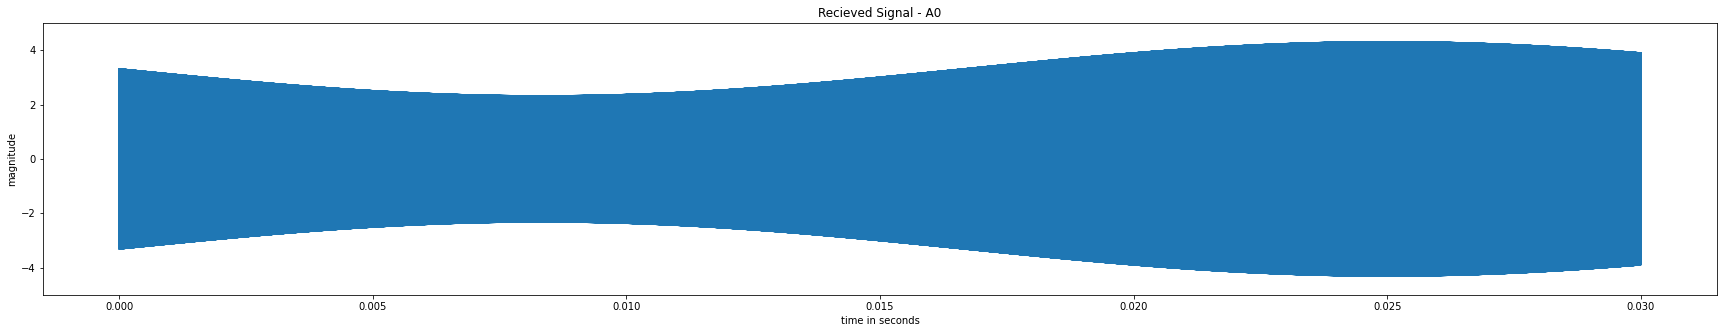

In [ ]:
# Received signal - A0

plt.figure(figsize=(30,5))
plt.plot(time[:300000], VA0[:300000])
plt.ylim((-5 ,5))
plt.title('Recieved Signal - A0')
plt.xlabel('time in seconds')
plt.ylabel('magnitude')
plt.show()

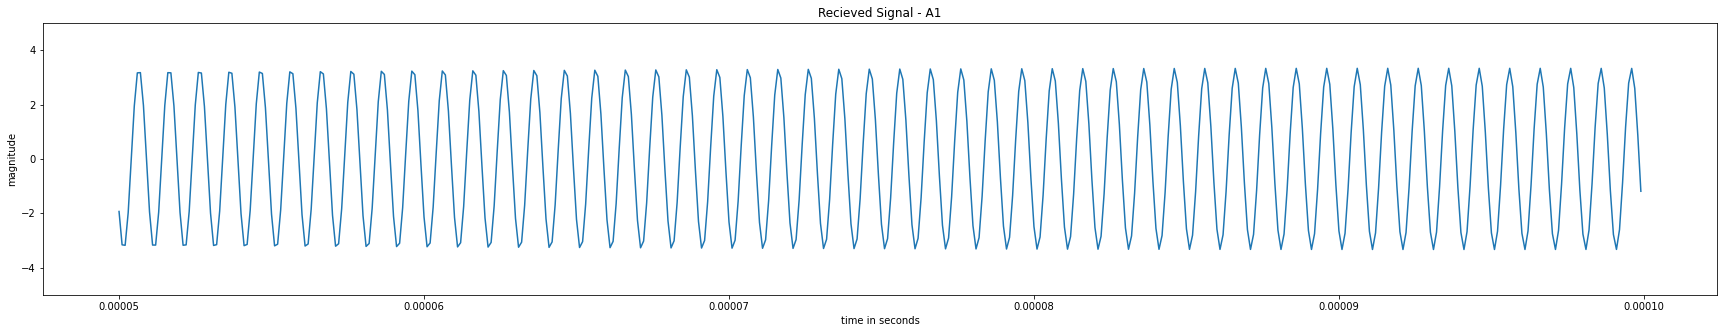

In [6]:
# Received signal - A1

plt.figure(figsize=(30,5))
plt.plot(time[500:1000], VA1[500:1000])
plt.ylim((-5 ,5))
plt.title('Recieved Signal - A1')
plt.xlabel('time in seconds')
plt.ylabel('magnitude')
plt.show()

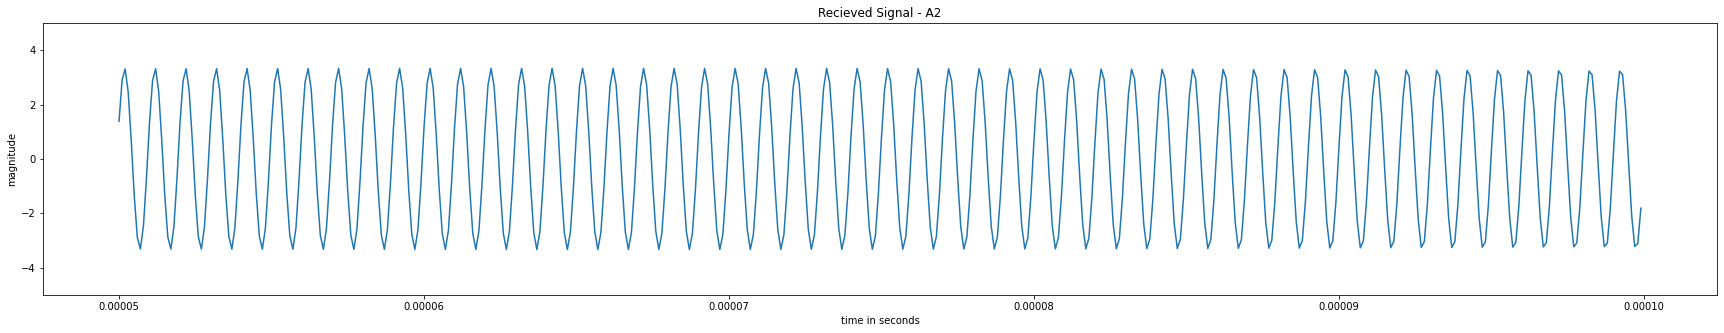

In [7]:
# Received signal - A2

plt.figure(figsize=(30,5))
plt.plot(time[500:1000], VA2[500:1000])
plt.ylim((-5 ,5))
plt.title('Recieved Signal - A2')
plt.xlabel('time in seconds')
plt.ylabel('magnitude')
plt.show()

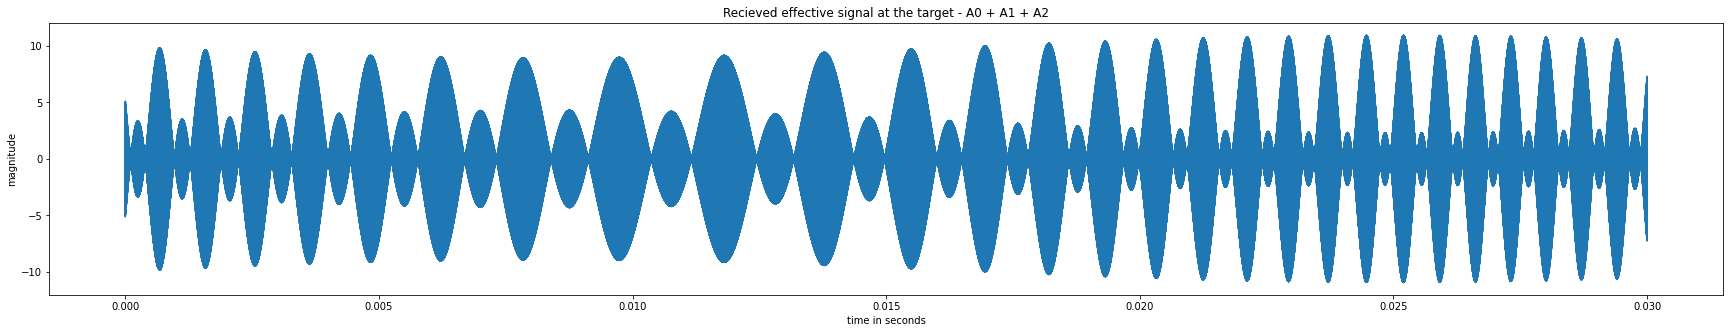

In [8]:
received = VA0 + VA1 + VA2

plt.figure(figsize=(30,5))
plt.plot(time[0:300000], received[0:300000])
plt.title('Recieved effective signal at the target - A0 + A1 + A2')
plt.xlabel('time in seconds')
plt.ylabel('magnitude')
plt.show()

# **Q4**

In [9]:
#supporting functions

def plot_FFT(abs_FFT,F_s,range,name):

  N = len(abs_FFT)
  freq_axis = np.fft.fftfreq(N, 1/F_s)
  plt.figure(figsize=(20, 5))
  ax=plt.ylabel('$|V(f)|^2$')
  ax=plt.xlabel('Frequency (Hz)')
  ax=plt.title('Frequency Response of :  '+name)
  plt.xlim(range)
  ax=plt.plot(freq_axis,  (2/N)*abs_FFT)

  return None

def LPF(cutoff,fs,N,plot,name):
  H = np.zeros((1,N))
  H[0,0:cutoff+1] = np.ones((1,cutoff+1))
  H[0,-cutoff:] = np.ones((1,cutoff))
  H=H[0]
  print(H.shape)

  if plot:
    plt.figure(figsize=(20,4))
    ax=plt.ylabel('$|H(f)|^2$')
    ax=plt.xlabel('Frequency (Hz)')
    ax=plt.title('Lowpass filter for : '+name)
    plt.plot(H,color='r')
    plt.xlim((0,cutoff+50))
  return H


def BPF(cutoff_L,cutoff_R,fs,N,plot,name):
  L_idx = cutoff_L
  R_idx = cutoff_R

  H = np.zeros((1,N))
  print(H.shape)
  H[0,cutoff_L:cutoff_R+1 ]= np.ones((1,cutoff_R-cutoff_L+1))
  H[0,-cutoff_R-1:-cutoff_L]=np.ones((1,cutoff_R-cutoff_L+1))
  H = H[0]
  print(H.shape)

  if plot:
    plt.figure(figsize=(20,4))
    ax=plt.ylabel('$|H(f)|^2$')
    ax=plt.xlabel('Frequency (Hz)')
    ax=plt.title('Banpass filter for : '+name)
    plt.plot(H,color='r')
    plt.xlim((0,cutoff_R+50))
  return H

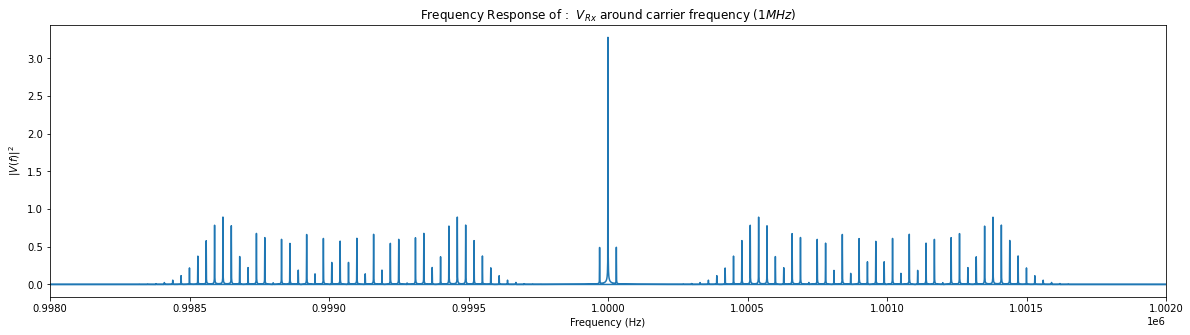

In [11]:
#Frequency Domain Response
Rx_FFT=np.fft.fft(received)
abs_Rx_FFT = (np.abs(Rx_FFT)**1).flatten()

plot_FFT(abs_Rx_FFT,sampling_frq,(1e6-2000,1e6+2000),'$V_{Rx}$ around carrier frequency ($1 MHz$)')

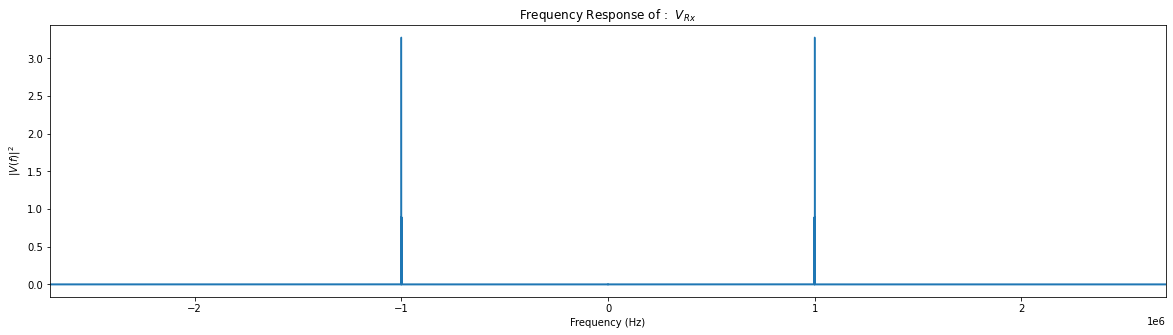

In [12]:
#define axes
N = len(abs_Rx_FFT)
freq_axis = np.fft.fftfreq(N, 1/sampling_frq)

plot_FFT(abs_Rx_FFT,sampling_frq,(-2.7e6,2.7e6),'$V_{Rx}$')

(10000001,)


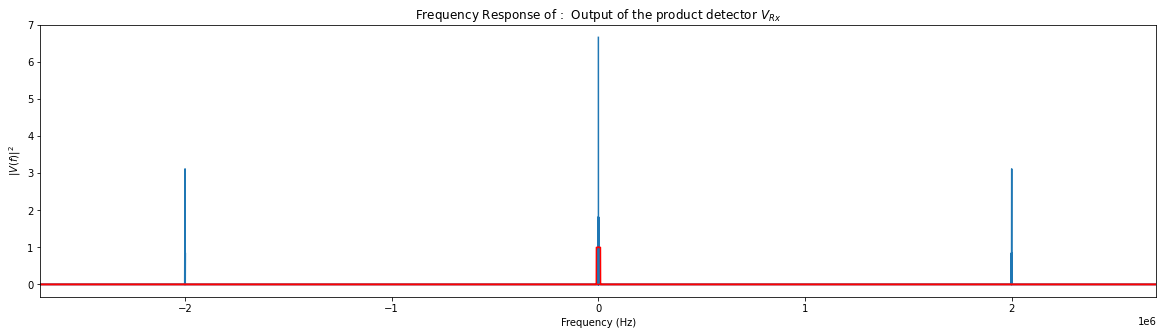

In [16]:
V_mod = received*(2*np.sin(angular_velocity_carrier*time-phase_shift)) 

mod_FFT=np.fft.fft(V_mod)
mod_abs_FFT = (np.abs(mod_FFT)**1).flatten()

H0_LPF=LPF(10000,sampling_frq,len(V_mod),0,'filter product detector output')
plot_FFT(mod_abs_FFT,sampling_frq,(-2.7e6,2.7e6),'Output of the product detector $V_{Rx}$')
plt.plot(freq_axis,H0_LPF,'r')
plt.show()

W_mod = mod_FFT*H0_LPF
W_mod[0] = 0

V_demod = np.real(np.fft.ifft(W_mod))

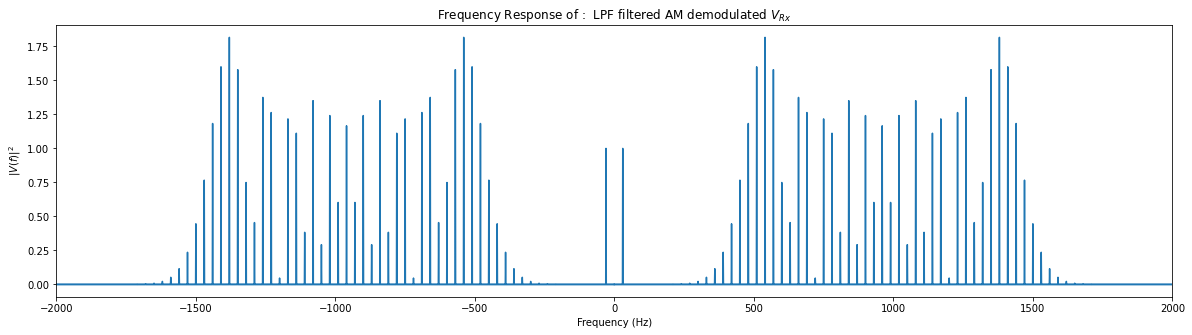

In [14]:
plot_FFT((np.abs(W_mod)**1).flatten(),sampling_frq,(-2000,2000),'LPF filtered AM demodulated $V_{Rx}$') 

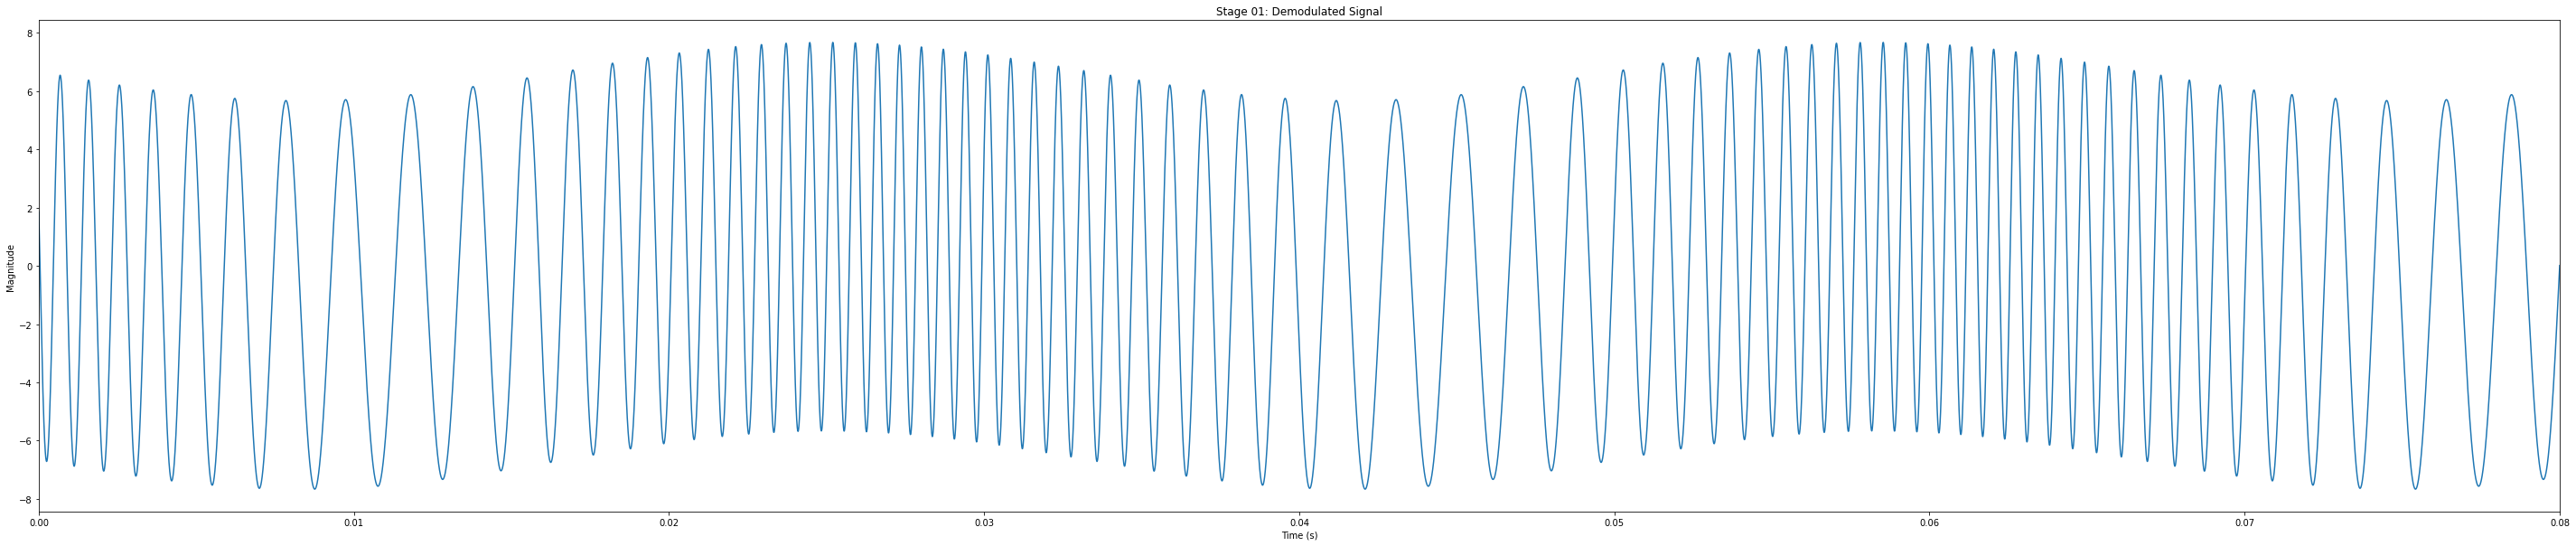

In [15]:
fig= plt.figure(figsize=(50,10))
plt.plot(time, V_demod)
plt.title('Stage 01: Demodulated Signal')
plt.xlabel('Time (s)') 
plt.ylabel('Magnitude')
plt.xlim((0, 0.08))
plt.show()

In [18]:
#filtering out 30Hz reference signal

freq_axis = np.fft.fftfreq(N, 1/sampling_frq)
H_LPF=LPF(35,sampling_frq,len(abs_Rx_FFT),0,'30Hz reference signal')
W_filt_ref = W_mod*H_LPF
filtered_ref = np.real(np.fft.ifft(W_filt_ref))

(10000001,)


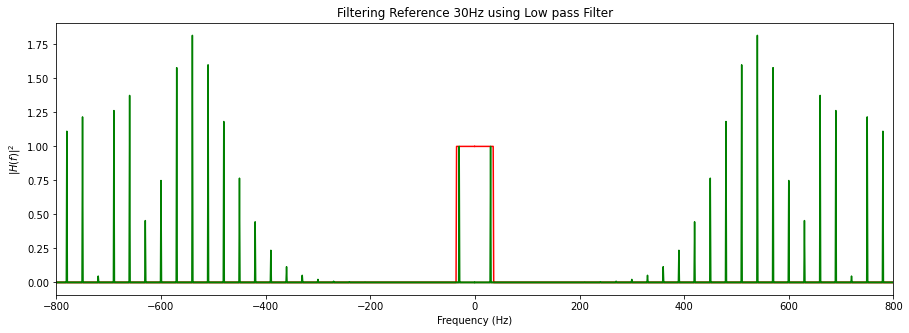

In [19]:
plt.figure(figsize=(15,5))
plt.plot(freq_axis,H_LPF,"r")
plt.plot(freq_axis,2.0/(N) *np.abs(W_mod),"g")
plt.xlabel('Frequency (Hz)')
plt.ylabel('$|H(f)|^2$')
plt.title('Filtering Reference 30Hz using Low pass Filter')
plt.xlim((-800,800))
plt.show()

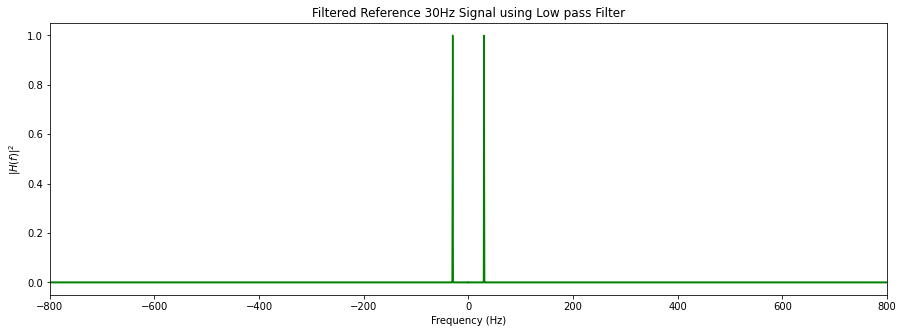

In [20]:
plt.figure(figsize=(15,5))
plt.plot(freq_axis,2.0/(N) *np.abs(W_filt_ref),"g")
plt.xlabel('Frequency (Hz)')
plt.ylabel('$|H(f)|^2$')
plt.title('Filtered Reference 30Hz Signal using Low pass Filter')
plt.xlim((-800,800))
plt.show()

In [24]:
ref_signal = -np.sin(angular_velocity_rotation*time)

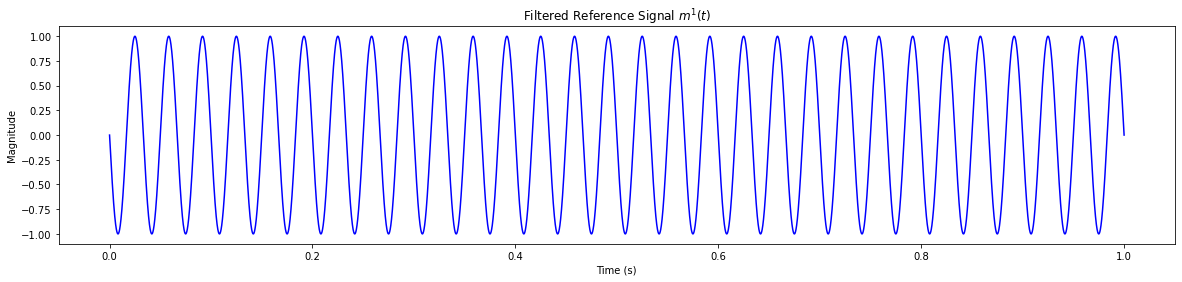

In [23]:
fig= plt.figure(figsize=(20,4))
plt.plot(time, filtered_ref, 'b',label="Filtered reference signal")
plt.title('Filtered Reference Signal $m^1(t)$')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.show()

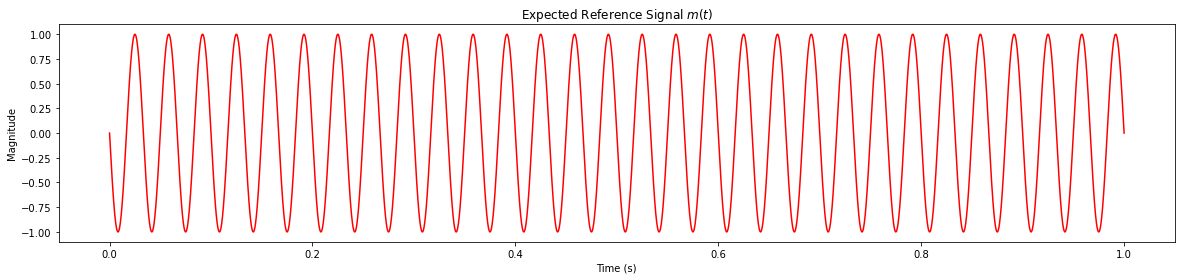

In [25]:
fig= plt.figure(figsize=(20,4))
plt.plot(time, ref_signal, 'r',label="Orginal (Ideal) reference signal")
plt.title('Expected Reference Signal $m(t)$')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.show()

In [26]:
#variable reference signal
original_var_reference = 2*inverse*np.cos(angular_velocity_offset*time + mod_index_FM*np.cos(angular_velocity_rotation*time-angle))

H_BPF=BPF(offset_freq-700,offset_freq+700,sampling_frq,len(abs_Rx_FFT),0,'30Hz variable reference signal')

W_filt_var = W_mod*H_BPF
filt_var_ref_comp = (np.fft.ifft(W_filt_var))
filt_var_ref = np.real(filt_var_ref_comp)

(1, 10000001)
(10000001,)


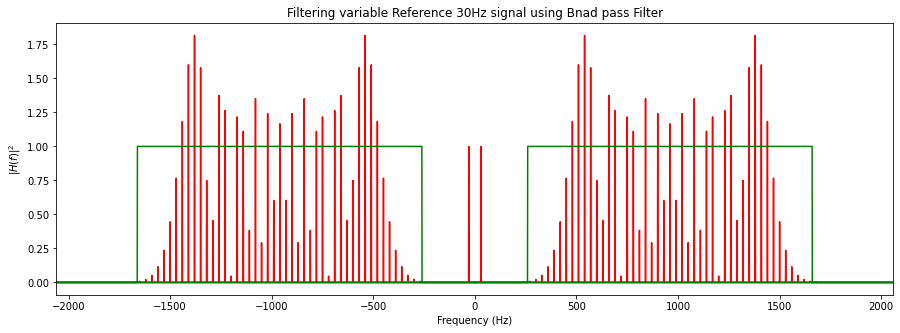

In [27]:
plt.figure(figsize=(15,5))
plt.plot(freq_axis, 2.0/N * np.abs(W_mod),"r")
plt.plot(freq_axis,H_BPF,"g")
plt.xlabel('Frequency (Hz)')
plt.ylabel('$|H(f)|^2$')
plt.title('Filtering variable Reference 30Hz signal using Bnad pass Filter')
plt.xlim((-2060,2060))
plt.show()

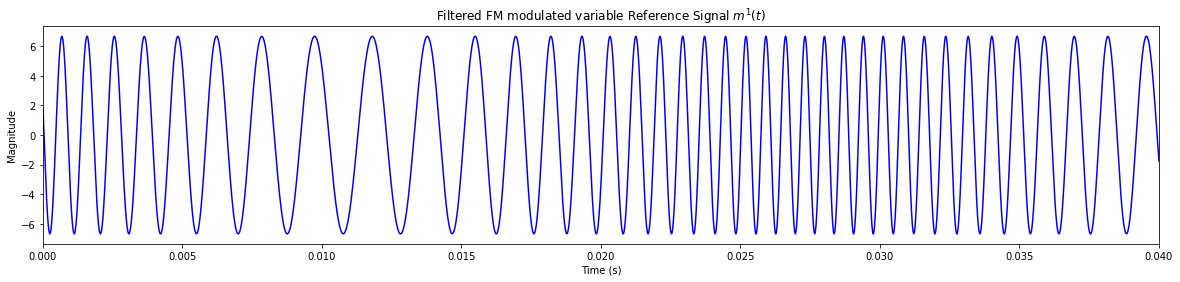

In [28]:
fig= plt.figure(figsize=(20,4))
plt.plot(time, filt_var_ref, 'b',label="Filtered FM modulated variable reference signal")
plt.title('Filtered FM modulated variable Reference Signal $m^1(t)$')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.xlim((0,0.04))
plt.show()

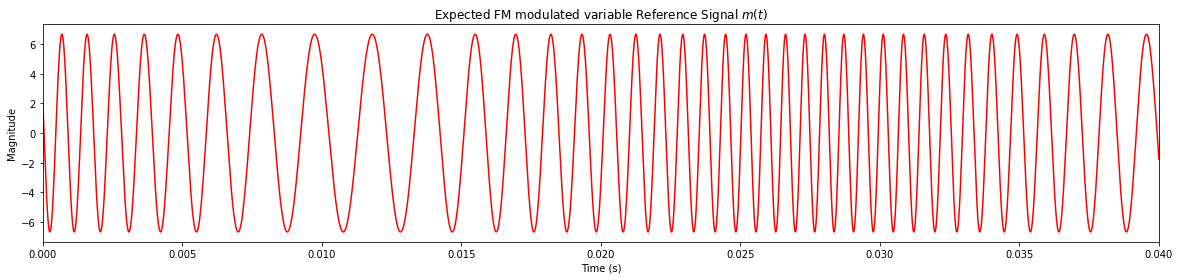

In [29]:
fig= plt.figure(figsize=(20,4))
plt.plot(time, original_var_reference, 'r',label="Orginal FM modulated variable reference signal")
plt.title('Expected FM modulated variable Reference Signal $m(t)$')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.xlim((0,0.04))
plt.show()

In [30]:
def fm_discriminator(x, freq_dev, f_c,t=time):

    R_x = hilbert(x)*np.exp(-1j*2*np.pi*f_c*t)

    phi = np.arctan2(np.imag(R_x), np.real(R_x))
    ret = np.diff(np.unwrap(phi)/(2*math.pi*freq_dev))*t.shape[0]

    return ret

In [31]:
fitered_var=fm_discriminator(np.real(filt_var_ref), freq_dev=30*16,f_c=angular_velocity_offset)
fitered_var=(fitered_var-np.mean(fitered_var))

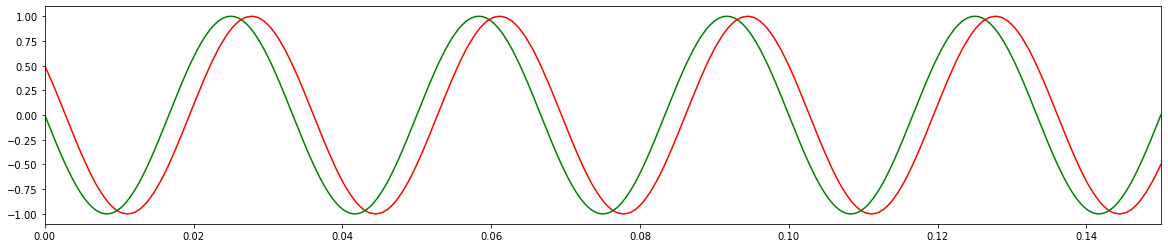

In [32]:
fig= plt.figure(figsize=(20,4))
plt.plot(time[:-1], np.real(fitered_var), 'r',label="Demodulated")
orig_FM = -np.sin(angular_velocity_rotation*time - angle)
plt.plot(time[:-1], filtered_ref[:-1], 'g',label="Demodulated")
plt.xlim((0,0.15))
plt.show()

In [33]:
#phase extraction

ref_fft = np.fft.fft(filtered_ref - np.mean(filtered_ref))
var_fft = np.fft.fft(fitered_var- np.mean(fitered_var))

#get the w_m frequency bin
var_fft_bin= np.argmax(abs(var_fft))
ref_fft_bin = np.argmax(abs(ref_fft))

var_phase=np.angle(var_fft[var_fft_bin])
ref_phase=np.angle(ref_fft[ref_fft_bin])

phase_diff=np.abs(var_phase-ref_phase)

print('phase difference : ',np.round(phase_diff*180/math.pi,2),'deg')

phase difference :  150.0 deg


# **Q5**

In [34]:
antennas=48
blend_freq= (np.pi*rotation_freq)/(2*(2*np.pi / antennas))
pulse_width= 2/(rotation_freq*antennas)
print("cosine blending frequency: ", blend_freq)

cosine blending frequency:  360.0


In [35]:
halfw_sampled=int(0.5*pulse_width*sampling_frq)+1
sample_period=int(sampling_frq/rotation_freq)+1
rep=31
beta=360/antennas

t_arr=np.arange(0,2/rotation_freq,1/sampling_frq)

In [36]:
discr_sin=np.sin(blend_freq*t_arr)
discr_sin[2*halfw_sampled-1:sample_period]=0
odd_func=np.array(list(discr_sin[:sample_period])*rep)

discr_cos=np.cos(blend_freq*t_arr)
discr_cos[halfw_sampled-1:sample_period-halfw_sampled]=0
even_func=np.array(list(discr_cos[:sample_period])*rep)

In [37]:
V_Rx=0

for i in range(antennas):
  if i==0:
    angle1=beta/2
    pulse=even_func
  else:
    angle1+=beta
    pulse=np.array(list(np.zeros(((i-1)*halfw_sampled)))+list(odd_func))
  blend=pulse[0:N]
  dx=radius*np.cos((angle-angle1)*np.pi/180)
  phi_1=2*np.pi*(distance-dx)/wave_length
  phi_2=2*np.pi*(distance+dx)/wave_length

  upper_sp=inverse*np.sin(2*np.pi*(carrier_freq+offset_freq)*time-phi_1)*blend
  lower_sp=inverse*np.sin(2*np.pi*(carrier_freq-offset_freq)*time-phi_2)*blend
  V_Rx+=upper_sp+lower_sp

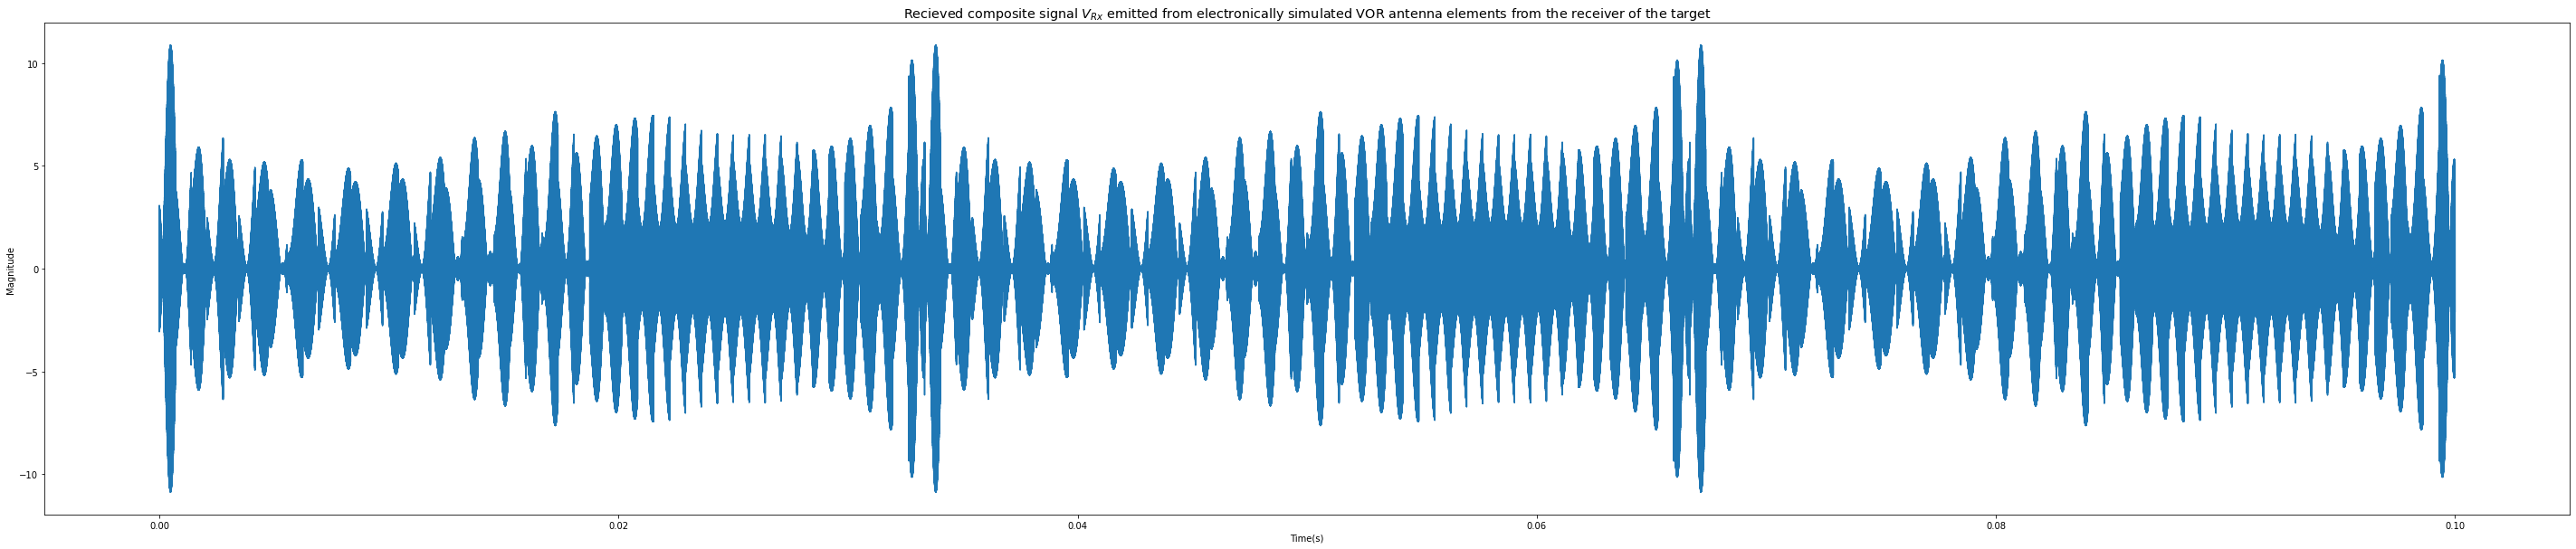

In [38]:
plt.figure(figsize=(50,10))
plt.plot(time[0:1000000], (VA0+V_Rx)[0:1000000])
plt.title('Recieved composite signal $V_{Rx}$ emitted from electronically simulated VOR antenna elements from the receiver of the target',fontsize='x-large')
plt.xlabel('Time(s)')
plt.ylabel('Magnitude')
plt.show()

In [39]:
elect_fft = (np.fft.fft(inverse*(1-mod_index_AM*np.sin(angular_velocity_rotation*time))*np.sin(angular_velocity_carrier*time-phase_shift)+V_Rx))

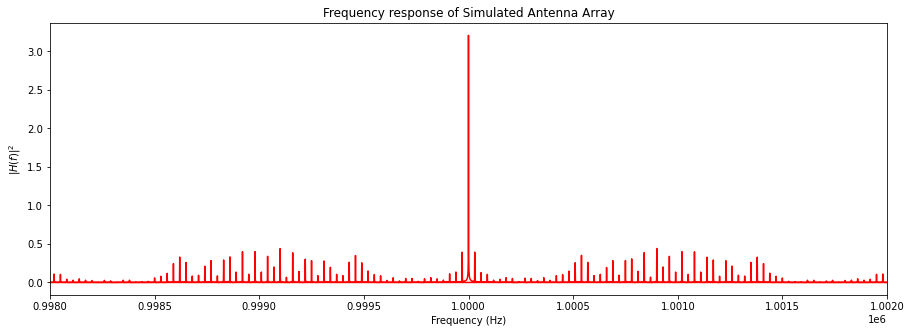

In [40]:
plt.figure(figsize=(15,5))
plt.plot(freq_axis, 2.0/N * np.abs(elect_fft),"r")
plt.xlabel('Frequency (Hz)')
plt.ylabel('$|H(f)|^2$')
plt.title('Frequency response of Simulated Antenna Array')
plt.xlim((1e6-2000,1e6+2000))
plt.show()

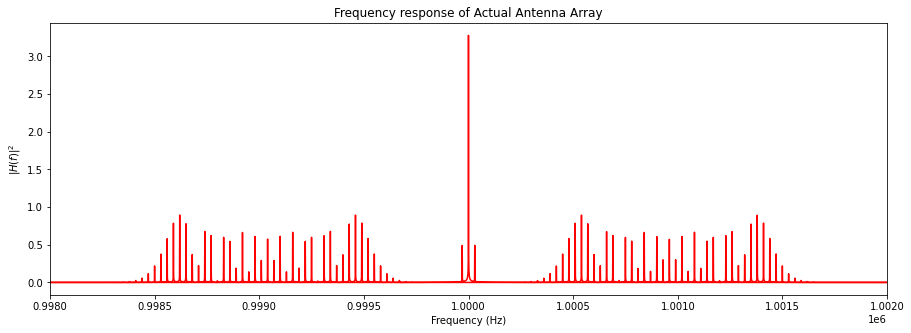

In [41]:
plt.figure(figsize=(15,5))
plt.plot(freq_axis, 2.0/N * np.abs(Rx_FFT),"r")
plt.xlabel('Frequency (Hz)')
plt.ylabel('$|H(f)|^2$')
plt.title('Frequency response of Actual Antenna Array')
plt.xlim((1e6-2000,1e6+2000))
plt.show()